### Import libs

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#Model
from sklearn.ensemble import RandomForestClassifier
#Train test split
from sklearn.model_selection import train_test_split
#Mean Absolute Error
from sklearn.metrics import mean_absolute_error
#Imputer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
#Column transformer
from sklearn.compose import ColumnTransformer
#Pipeline
from sklearn.pipeline import Pipeline
#OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
#Category Encoder 
#https://www.kaggle.com/matleonard/categorical-encodings
import category_encoders as ce
#Cross validation
from sklearn.model_selection import cross_val_score

### Get the data

In [2]:
#Load training data 
train_data = pd.read_csv("kaggle/input/titanic/train.csv")
#Load test data
test_data = pd.read_csv("kaggle/input/titanic/test.csv")

###  Look at the data

In [2]:
train_data.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Osen, Mr. Olaf Elon",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


<b>We have some missing values for the variables "Age", "Cabin" and "Embarked".<br>
Someone in a forum pointed out that it is possible to fill in the "Embarked" variable manually by searching the name of the passenger on google.<br>
For "Cabin" and "Age", we will probably impute the missing values.
    <br><br>
Let's create a variable "FamilySize" to sum up "SibSp" and "Parch" which are the number of siblings / spouses and the number of parents / children aboard the Titanic.

<AxesSubplot:xlabel='Familysize', ylabel='Survived'>

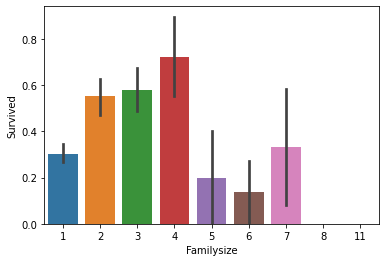

In [3]:
train_data["Familysize"] = train_data["SibSp"] + train_data["Parch"] + 1
test_data["Familysize"]  = test_data["SibSp"] + test_data["Parch"] + 1

sns.barplot(x = "Familysize", y ="Survived", data=train_data)

<b>The probablity to survive is different based on the number of family members travelling with a passenger. <br>
    Based on this information, we will group the number of family members by likelihood to survive, and create a binary variable which tells us if a passenger travel alone or with family:

<AxesSubplot:xlabel='Travelalone', ylabel='Survived'>

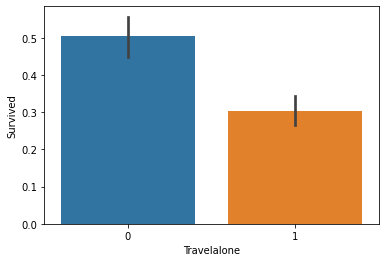

In [4]:
train_data["Travelalone"] = [1 if fam == 1 else 0 for fam in train_data["Familysize"]]
train_data["Familysize"].replace([1,2,3,4,5,6,7,8,11], [1,2,2,2,1,3,3,3,3], inplace=True)

test_data["Travelalone"] = [1 if fam == 1 else 0 for fam in test_data["Familysize"]]
test_data["Familysize"].replace([1,2,3,4,5,6,7,8,11], [1,2,2,2,1,3,3,3,3], inplace=True)

sns.barplot(x = "Travelalone", y ="Survived", data=train_data)

<b>As we can see, someone who travels alone is less likely to survive than someone with a family onboard.<br>
<br>

### Feature selection

In [5]:
#Select features and split between numerical and categorical cols
numerical_cols   = ["Age", "Fare"]
categorical_cols = ["Pclass", "Sex", "Familysize", "Embarked"]
#Keep selected cols only
my_cols = categorical_cols + numerical_cols

<b>Smart impute Embarked

In [6]:
train_data.loc[train_data["Embarked"].isnull(), "Embarked"] = "S"
test_data.loc[test_data["Embarked"].isnull(), "Embarked"] = "S"

### Preprocess the data

In [7]:
#Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy="mean")
#Preprocessing for categorical data
    
categorical_transformer = Pipeline(steps=[
                                          ('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('encoder', OneHotEncoder(handle_unknown='ignore'))
                                         ])
#Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(transformers=[
                                               ('num', numerical_transformer, numerical_cols),
                                               ('cat', categorical_transformer, categorical_cols)
                                              ])

### Create datasets for the model

In [8]:
#Remove null target data if any
train_data.dropna(axis=0, subset=['Survived'], inplace=True)
y = train_data["Survived"]
train_data.drop(["Survived"], axis=1, inplace=True)
X = train_data.copy()

### Define the model

<b> Let's use a simple random forest

In [14]:
randomforest = RandomForestClassifier(n_estimators = 1000, max_depth = 7, random_state = 1)

### Bundle preprocessing and modeling code in a pipeline

In [10]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', randomforest)])
#fit model 
my_pipeline.fit(X[my_cols], y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex',
                                                   'Familysize',
                                                   'Embarked'])])),
                ('model',
                 RandomForestClassifier(max_depth=7, min_samples_leaf=6,
                                        min_samples_split=6, n_estimators=1000,
             

### Generate predictions and submit to competition

In [12]:
#Apply on test data
X_test  = test_data[my_cols].copy()
#Fit the model
predictions = my_pipeline.predict(X_test)

#Output the submission
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


### Failed attempts at improving my score

<b>
Using different models didn't improve the score, random forest was the best one for me
<br><br>
I used a function to get the MAE of my model and use it as metric to improve my model, but a lower MAE didn't necessarily mean a better score on the test data. My model was probably overfitting, so I had to rely on trial and error to improve my score.
<br><br>
Out of all the features engineering that I performed, only grouping "SibSp" and "Parch" into "FamilySize" proved effective.
I tried to extract the title (Mr, Ms, Dr etc.) from the name of the passenger, group the age variable into age categories, or dividing the price of the ticket by the family size, without success.
<br><br>